## Experiment 5.
##### This experiment compares various pre-trained models and also uses early stopping
##### The pre-trained models used are:
- VGG-19
- ResNet50
- Xception
- DenseNet121

In [68]:
import tensorflow as tf
from tensorflow.python.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.python.keras.models import Model, load_model
from KyleNet import KyleNet
from pathlib import Path
from tensorflow.keras.applications import VGG19, ResNet50, Xception, DenseNet121
from tensorflow.keras.optimizers import Adam

# Get the metadata
META = Path(".").resolve().parent.joinpath("metadata.csv")
import matplotlib.pyplot as plt

In [69]:
if tf.test.gpu_device_name():
    print(f"GPU Device: {tf.test.gpu_device_name()}\n")
else:
    print("Running off of CPU\n")

GPU Device: /device:GPU:0



##### Loops through all the pre-trained models to fetch the results

In [3]:
results = []
for model in [VGG19, ResNet50, Xception, DenseNet121]:
    print(f"\nTraining Model: {model.__name__}")

    # Configure the pre-trained model and make the input layers untrainable
    base_model = model(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    # FC layers from KyleNet
    output = Flatten()(base_model.output)
    output = Dense(32, activation="relu")(output)
    output = BatchNormalization()(output)
    output = Dense(1, activation="sigmoid")(output)

    base_model = Model(base_model.input, output)
    base_model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

    # KyleNet CNN gets swapped out on each loop
    exp5 = KyleNet(META,
                   f"Experiment 5 - {model.__name__}",
                   epochs=50,
                   balance_dataset=True,
                   use_early_stopping=True)
    exp5.model = base_model

    # Save and train the model
    history = exp5.Train()
    exp5.Evaluate()
    predictions = exp5.Predict()
    exp5.Save()

    results.append([model.__name__, history, predictions])


Training Model: VGG19
Found 57830 validated image filenames belonging to 2 classes.
Found 19276 validated image filenames belonging to 2 classes.
Epoch 1/50
451/451 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9790  

In [4]:
# Mock instance, only used to access the methods that show model performance
test = KyleNet(META, "", balance_dataset=True)

Found 57830 validated image filenames belonging to 2 classes.
Found 19276 validated image filenames belonging to 2 classes.


##### View the classification report for each model

In [70]:
for index, result in enumerate(results):
    print(f"{'-'*50}\nReport for {result[0]}\n")
    test.MetricReport(result[2])
    print("-"*50)

--------------------------------------------------
Report for VGG19

              precision    recall  f1-score   support

    COVID-19       0.50      0.50      0.50      9611
   NON-COVID       0.50      0.51      0.50      9665

    accuracy                           0.50     19276
   macro avg       0.50      0.50      0.50     19276
weighted avg       0.50      0.50      0.50     19276

--------------------------------------------------
--------------------------------------------------
Report for ResNet50

              precision    recall  f1-score   support

    COVID-19       0.50      0.48      0.49      9611
   NON-COVID       0.50      0.52      0.51      9665

    accuracy                           0.50     19276
   macro avg       0.50      0.50      0.50     19276
weighted avg       0.50      0.50      0.50     19276

--------------------------------------------------
--------------------------------------------------
Report for Xception

              precision    reca

##### View the acc/loss graphs of each model

Row 1: VGG19
Row 2: ResNet50
Row 3: Xception
Row 4: DenseNet121


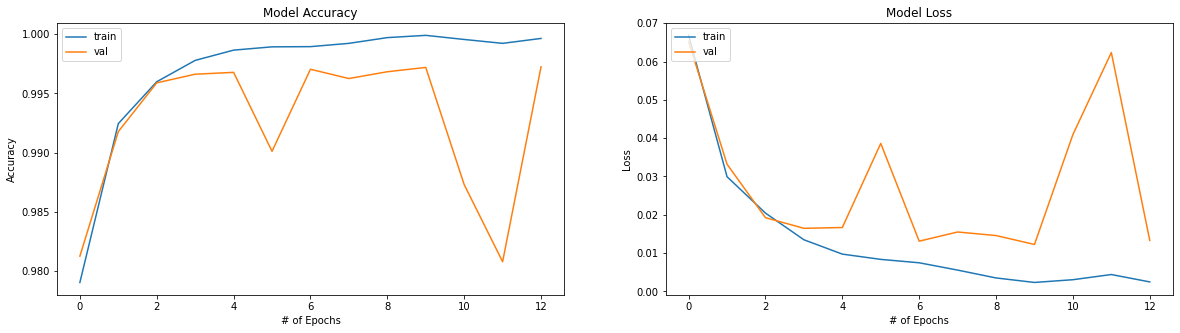

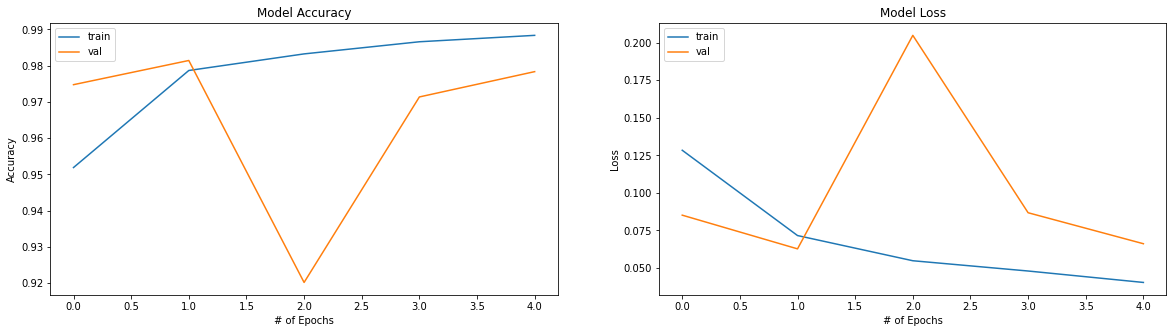

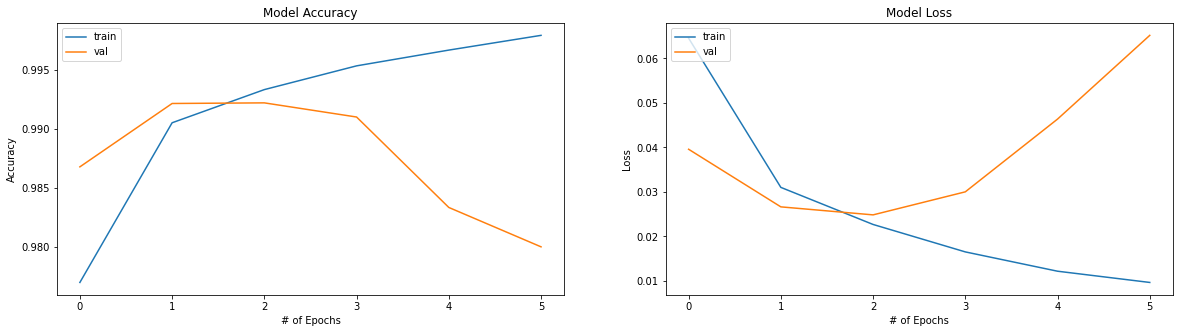

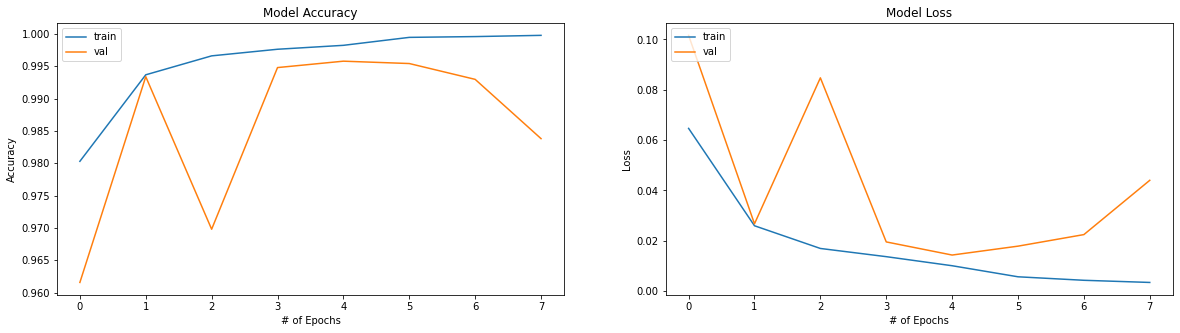

In [71]:
for index, result in enumerate(results):
    print(f"Row {index+1}: {result[0]}")
    test.PlotHistory(result[1])

##### View the ROC curve of each model

Row 1: VGG19
Row 2: ResNet50
Row 3: Xception
Row 4: DenseNet121


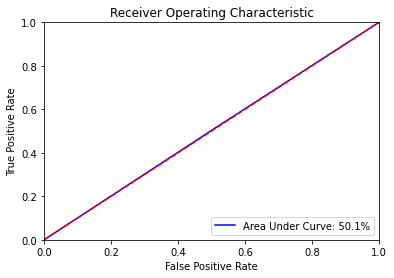

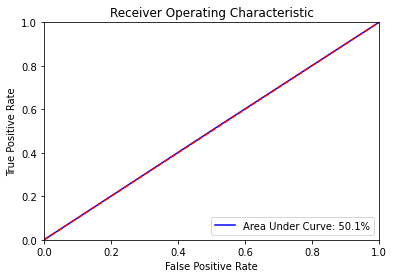

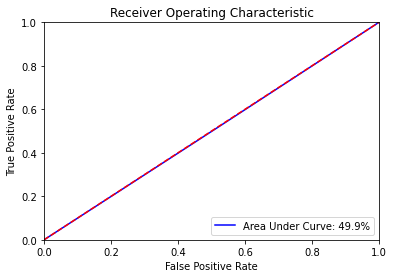

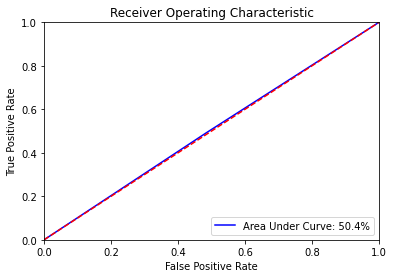

In [91]:
for index, result in enumerate(results):
    print(f"Row {index+1}: {result[0]}")
    test.ROC(result[2])

##### Compare the accuracies of each pre-trained model

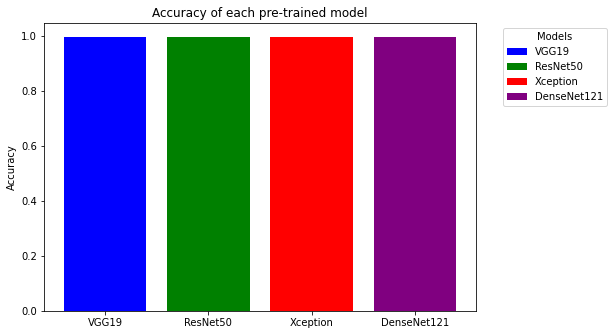

In [73]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
accuracy = [result[1].history["val_accuracy"][-1] for _, result in enumerate(results)]
model_names = [model[0] for _, model in enumerate(results)]
ax.set_title("Accuracy of each pre-trained model")
ax.set_ylabel('Accuracy')
ax.bar(model_names[0], accuracy, color = 'blue')
ax.bar(model_names[1], accuracy, color = 'green')
ax.bar(model_names[2], accuracy, color = 'red')
ax.bar(model_names[3], accuracy, color = 'purple')
ax.legend(labels=model_names, title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()